In [1]:
"""
Field Name	Definition
AsOfDate	Date when the data was recorded
Program	Indicator of whether loan was approved under SBA's 7(a) or 504 loan program
BorrName	Borrower name
BorrStreet	Borrower street address
BorrCity	Borrower city
BorrState	Borrower state
BorrZip	Borrower zip code
CDC_Name	Name of CDC that the loan is currently assigned to
CDC_Street	CDC street address
CDC_City	CDC city
CDC_State	CDC state
CDC_Zip	CDC zip code
ThirdPartyLender_Name	Name of third party lender
ThirdPartyLender_City	Third party lender city
ThirdPartyLender_State	Third party lender state
ThirdPartyDollars	Third party loan amount
GrossApproval	SBA/CDC loan amount
ApprovalDate	Date the loan was approved
ApprovalFiscalYear	Fiscal year the loan was approved
FirstDisbursementDate	Date of first loan disbursement (if available)
DeliveryMethod	"Specific delivery method loan was approved under.  See SOP 50 10 5 for definitions and rules for each delivery method.  
504 Delivery Methods:
• 504 = Regular 504
• 504REFI = 504 Refinance (inactive)
• ALP = Accredited Lenders Program
• PCLP = Premier Certified Lenders "
Subprogram	Subprogram description - specific subprogram loan was aproved under.  See SOP 50 10 5 for definitions and rules for each subprogram.
TermInMonths	Length of loan term
NaicsCode	North American Industry Classification System (NAICS) code
NaicsDescription	North American Industry Classification System (NAICS) description
FranchiseCode	Franchise Code
FranchiseName	Franchise Name (if applicable)
ProjectCounty	County where project occurs
ProjectState	State where project occurs
SBADistrictOffice	SBA district office
CongressionalDistrict	Congressional district where project occurs
BusinessType	Borrower Business Type - Individual, Partnership, or Corporation
BusinessAge	"SBA began collecting the following business age information in fiscal year 2018:  
• Change of Ownership
• Existing or more than 2 years old
• New Business or 2 years or less
• Startup, Loan Funds will Open Business"
LoanStatus	"Current status of loan:  
• NOT FUNDED = Undisbursed
• PIF = Paid In Full
• CHGOFF = Charged Off
• CANCLD = Cancelled
• EXEMPT = The status of loans that have been disbursed but have not been cancelled, paid in full, or charged off are exempt from disclosure under FOIA Exemption 4"
PaidInFullDate	Date loan was paid in full (if applicable)
ChargeOffDate	Date SBA charged off loan (if applicable)
GrossChargeOffAmount	Total SBA/CDC loan balance charged off
JobsSupported	Total Jobs Created + Jobs Retained as reported by lender on SBA Loan Application.  SBA does not review, audit, or validate these numbers - they are simply self-reported, good faith estimates by the lender.

"""


'\nField Name\tDefinition\nAsOfDate\tDate when the data was recorded\nProgram\tIndicator of whether loan was approved under SBA\'s 7(a) or 504 loan program\nBorrName\tBorrower name\nBorrStreet\tBorrower street address\nBorrCity\tBorrower city\nBorrState\tBorrower state\nBorrZip\tBorrower zip code\nCDC_Name\tName of CDC that the loan is currently assigned to\nCDC_Street\tCDC street address\nCDC_City\tCDC city\nCDC_State\tCDC state\nCDC_Zip\tCDC zip code\nThirdPartyLender_Name\tName of third party lender\nThirdPartyLender_City\tThird party lender city\nThirdPartyLender_State\tThird party lender state\nThirdPartyDollars\tThird party loan amount\nGrossApproval\tSBA/CDC loan amount\nApprovalDate\tDate the loan was approved\nApprovalFiscalYear\tFiscal year the loan was approved\nFirstDisbursementDate\tDate of first loan disbursement (if available)\nDeliveryMethod\t"Specific delivery method loan was approved under.  See SOP 50 10 5 for definitions and rules for each delivery method.  \n504 De

In [2]:

import pandas as pd
import numpy as np
pd.set_option('display.max_rows',5000)
pd.set_option('display.max_columns',76)
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score,classification_report
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import seaborn as sns
import glob



# Importing data

In [3]:
paths = glob.glob("*.csv", recursive=True)

appended_file = []
for i in paths:
    com_df = pd.read_csv(i,encoding='latin-1')
    appended_file.append(com_df)
    df=pd.concat(appended_file, axis=0, ignore_index=True, sort=False)

In [4]:
df['LoanStatus'].value_counts(normalize=True)

LoanStatus
PIF           0.589487
EXEMPT        0.164286
CANCLD        0.118537
CHGOFF        0.112109
COMMIT        0.011339
NOT FUNDED    0.004241
Name: proportion, dtype: float64

# Filtering data

In [5]:
df_filtererd=df[(df['LoanStatus']=='PIF') | (df['LoanStatus']=='CHGOFF')]
df_filtererd['ApprovalDate'] = pd.to_datetime(df_filtererd['ApprovalDate'], errors='coerce')
df_filtererd['ApprovalYear'] = df_filtererd['ApprovalDate'].dt.year
df_filtererd['ApprovalMonth'] = df_filtererd['ApprovalDate'].dt.month
df_filtererd.drop_duplicates(inplace=True)

In [6]:
df_filtererd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337631 entries, 0 to 1894940
Data columns (total 52 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   AsOfDate                    1337631 non-null  int64         
 1   Program                     1337631 non-null  object        
 2   BorrName                    1337602 non-null  object        
 3   BorrStreet                  1337528 non-null  object        
 4   BorrCity                    1337608 non-null  object        
 5   BorrState                   1337605 non-null  object        
 6   BorrZip                     1337631 non-null  int64         
 7   CDC_Name                    30684 non-null    object        
 8   CDC_Street                  30684 non-null    object        
 9   CDC_City                    30684 non-null    object        
 10  CDC_State                   30684 non-null    object        
 11  CDC_Zip                     3

In [7]:
df_filtererd.isnull().sum()/len(df)*100

AsOfDate                       0.000000
Program                        0.000000
BorrName                       0.001521
BorrStreet                     0.005401
BorrCity                       0.001206
BorrState                      0.001363
BorrZip                        0.000000
CDC_Name                      68.527111
CDC_Street                    68.527111
CDC_City                      68.527111
CDC_State                     68.527111
CDC_Zip                       68.527111
ThirdPartyLender_Name         68.527425
ThirdPartyLender_City         68.527897
ThirdPartyLender_State        68.528002
ThirdPartyDollars             68.527058
GrossApproval                  0.001416
ApprovalDate                   0.000000
ApprovalFiscalYear             0.000000
FirstDisbursementDate          0.157981
DeliveryMethod                 0.001416
Subprogram                     0.012846
TermInMonths                   0.000000
NaicsCode                      9.226525
NaicsDescription               9.262231


In [8]:
df_filtererd['LoanStatus_num']=df_filtererd['LoanStatus'].apply(lambda x:0 if x=='PIF' else 1)
df_filtererd

,AsOfDate,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,CDC_Name,CDC_Street,CDC_City,CDC_State,CDC_Zip,ThirdPartyLender_Name,ThirdPartyLender_City,ThirdPartyLender_State,ThirdPartyDollars,GrossApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,Subprogram,TermInMonths,NaicsCode,NaicsDescription,FranchiseCode,FranchiseName,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,BusinessAge,LoanStatus,PaidInFullDate,ChargeOffDate,GrossChargeOffAmount,JobsSupported,BankName,BankFDICNumber,BankNCUANumber,BankStreet,BankCity,BankState,BankZip,SBAGuaranteedApproval,InitialInterestRate,FixedOrVariableInterestInd,RevolverStatus,SoldSecMrktInd,ApprovalYear,ApprovalMonth,LoanStatus_num
0,20240331,504,Turning Brook,300 & 400 Oxbow Dr 100 Villa,Alpena,MI,49707,Michigan Certified Development,"3737 Coolidge Road, 2nd Floor",East Lansing,MI,48823.0,MERCANTILE BANK,GRAND RAPIDS,MI,1767117.0,1248000.0,2009-10-02,2010,01/12/2011,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,623312.0,Homes for the Elderly,NaN,NaN,ALPENA,MI,MICHIGAN DISTRICT OFFICE,1.0,CORPORATION,NaN,PIF,12/31/2012,NaN,0,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,10,0
2,20240331,504,"Rocket Express, LLC",1122 Blue Laker Boulevard Nort,Twin falls,ID,83301,Region IV Development Corporat,202 Falls Avenue,Twin Falls,ID,83303.0,BANNER BANK,WALLA WALLA,WA,2634500.0,1594000.0,2009-10-02,2010,10/13/2010,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,811192.0,Car Washes,NaN,NaN,TWIN FALLS,ID,BOISE DISTRICT OFFICE,2.0,CORPORATION,NaN,PIF,09/30/2015,NaN,0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,10,0
3,20240331,504,Martin Harper P.C.,3 E. Ramona Avenue.,Colorado springs,CO,80905,Pikes Peak Regional Developmen,322 S. Cascade Avenue,Colorado Springs,CO,80903.0,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",COLUMBUS,OH,157583.0,127000.0,2009-10-02,2010,01/12/2011,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,541211.0,Offices of Certified Public Accountants,NaN,NaN,EL PASO,CO,COLORADO DISTRICT OFFICE,5.0,CORPORATION,NaN,PIF,11/30/2020,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,10,0
4,20240331,504,"Shield Security Systems, L.L.C",7456 West 5th Avenue.,Lakewood,CO,80226,B:Side Capital,3350 Brighton Blvd,Denver,CO,80216.0,"ZIONS BANK, A DIVISION OF",SALT LAKE CITY,UT,936500.0,757000.0,2009-10-02,2010,06/16/2010,PCLP,Sec. 504 - Premier Certified Lender Program,240,332510.0,Hardware Manufacturing,NaN,NaN,JEFFERSON,CO,COLORADO DISTRICT OFFICE,1.0,CORPORATION,NaN,PIF,05/31/2016,NaN,0,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,10,0
5,20240331,504,KT&apos;s Bowling Lanes,1501 S. Washington Avenue.,Emmett,ID,83617,"Capital Matrix, Inc.",6429 West Interchange Lane,Boise,ID,83709.0,KEYBANK NATIONAL ASSOCIATION,CLEVELAND,OH,179250.0,111000.0,2009-10-02,2010,11/17/2010,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,713950.0,Bowling Centers,NaN,NaN,GEM,ID,BOISE DISTRICT OFFICE,1.0,CORPORATION,NaN,PIF,10/31/2017,NaN,0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888830,20240331,7A,Gualtieri's Bakery LLC,420 E 9TH ST,ROCHESTER,IN,46975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13100.0,2023-12-21,2024,12/27/2023,SBA EXPRES,FA$TRK (Small Loan Express),59,311811.0,Retail Bakeries,NaN,NaN,FULTON,IN,INDIANA DISTRICT OFFICE,2.0,CORPORATION,"Startup, Loan Funds will Open Business",PIF,01/31/2024,NaN,0,1,1st Source Bank,9087.0,NaN,100 N Michigan St,SOUTH BEND,IN,46601,6550.0,11.75,F,0.0,NaN,2023,12,0
1889060,20240331,7A,All Star Power Excavation LLC,833 N. BRYS DR,GROSSE POINTE WOODS,MI,48236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212100.0,2023-12-21,2024,12/28/2023,SBA EXPRES,FA$TRK (Small Loan Express),84,488490.0,Other Support Activities 

In [9]:
df_filtererd['LoanStatus'].value_counts(normalize=True)

LoanStatus
PIF       0.84016
CHGOFF    0.15984
Name: proportion, dtype: float64

In [10]:
cols=[
    'AsOfDate',
 'Program',
 'BorrName',
 'BorrStreet',
 'BorrCity',
 'BorrState',
 'BorrZip',
 'GrossApproval',
 'ApprovalDate',
 'ApprovalFiscalYear',
 'FirstDisbursementDate',
 'DeliveryMethod',
 'Subprogram',
 'TermInMonths',
 'NaicsCode',
 'NaicsDescription',
 'ProjectCounty',
 'ProjectState',
 'SBADistrictOffice',
 'CongressionalDistrict',
 'BusinessType',
 'LoanStatus',
 #'PaidInFullDate',
 'GrossChargeOffAmount',
 'JobsSupported',
 'BankName',
 'BankFDICNumber',
 'BankStreet',
 'BankCity',
 'BankState',
 'BankZip',
 'SBAGuaranteedApproval',
 #'InitialInterestRate',
 #'FixedOrVariableInterestInd',
 'RevolverStatus',
 #'SoldSecMrktInd',
 'ApprovalYear',
 'ApprovalMonth','LoanStatus_num']
df_filtererd=df_filtererd[cols]
# df_filtererd.dropna(inplace=True)

In [11]:
df_filtererd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337631 entries, 0 to 1894940
Data columns (total 35 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   AsOfDate               1337631 non-null  int64         
 1   Program                1337631 non-null  object        
 2   BorrName               1337602 non-null  object        
 3   BorrStreet             1337528 non-null  object        
 4   BorrCity               1337608 non-null  object        
 5   BorrState              1337605 non-null  object        
 6   BorrZip                1337631 non-null  int64         
 7   GrossApproval          1337604 non-null  float64       
 8   ApprovalDate           1337631 non-null  datetime64[ns]
 9   ApprovalFiscalYear     1337631 non-null  int64         
 10  FirstDisbursementDate  1334618 non-null  object        
 11  DeliveryMethod         1337604 non-null  object        
 12  Subprogram             1337386 no

In [12]:
df_filtererd[cols].isnull().sum()/len(df)*100


AsOfDate                 0.000000
Program                  0.000000
BorrName                 0.001521
BorrStreet               0.005401
BorrCity                 0.001206
BorrState                0.001363
BorrZip                  0.000000
GrossApproval            0.001416
ApprovalDate             0.000000
ApprovalFiscalYear       0.000000
FirstDisbursementDate    0.157981
DeliveryMethod           0.001416
Subprogram               0.012846
TermInMonths             0.000000
NaicsCode                9.226525
NaicsDescription         9.262231
ProjectCounty            0.029939
ProjectState             0.002779
SBADistrictOffice        0.001206
CongressionalDistrict    0.162228
BusinessType             0.003198
LoanStatus               0.000000
GrossChargeOffAmount     0.000000
JobsSupported            0.000000
BankName                 1.608906
BankFDICNumber           7.768364
BankStreet               1.673923
BankCity                 1.673870
BankState                1.676125
BankZip       

In [13]:
df_filtererd['LoanStatus_num'].value_counts(normalize=True)

LoanStatus_num
0    0.84016
1    0.15984
Name: proportion, dtype: float64

In [14]:
cols=df_filtererd.columns
num_cols=df_filtererd.select_dtypes(include='number').columns
nonnum_cols=list(set(cols)-set(num_cols))
nonnum_cols

['FirstDisbursementDate',
 'Subprogram',
 'BorrState',
 'ProjectState',
 'BorrName',
 'BusinessType',
 'BankState',
 'ApprovalDate',
 'BankName',
 'DeliveryMethod',
 'ProjectCounty',
 'BankStreet',
 'BorrCity',
 'NaicsDescription',
 'LoanStatus',
 'BankZip',
 'BankCity',
 'BorrStreet',
 'Program',
 'SBADistrictOffice']

# Continous analysis

An error occurred: index 0 is out of bounds for axis 0 with size 0
Empty DataFrame
Columns: [bin, order_id Counts, order_id Percentages, NoShow Percentage]
Index: [] 



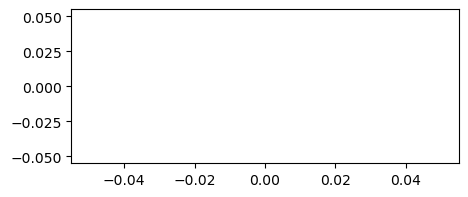

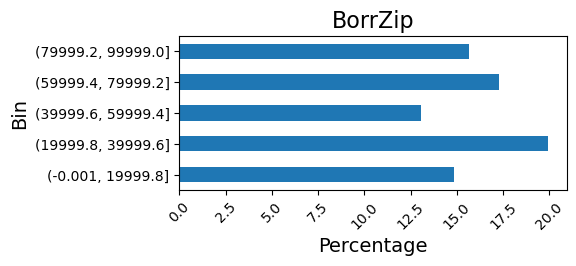

                  bin  order_id Counts  order_id Percentages  \
0   (-0.001, 19999.8]           293228             21.921442   
1  (19999.8, 39999.6]           208942             15.620302   
2  (39999.6, 59999.4]           233945             17.489502   
3  (59999.4, 79999.2]           236163             17.655317   
4  (79999.2, 99999.0]           365353             27.313437   

   NoShow Percentage  
0          14.842716  
1          19.944769  
2          13.075295  
3          17.263924  
4          15.670051   



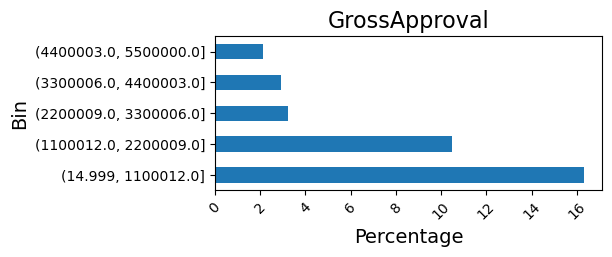

                      bin  order_id Counts  order_id Percentages  \
0     (14.999, 1100012.0]          1280531             95.731259   
1  (1100012.0, 2200009.0]            43902              3.282071   
2  (2200009.0, 3300006.0]             7819              0.584541   
3  (3300006.0, 4400003.0]             3156              0.235940   
4  (4400003.0, 5500000.0]             2196              0.164171   

   NoShow Percentage  
0          16.307141  
1          10.471049  
2           3.222919  
3           2.946768  
4           2.140255   



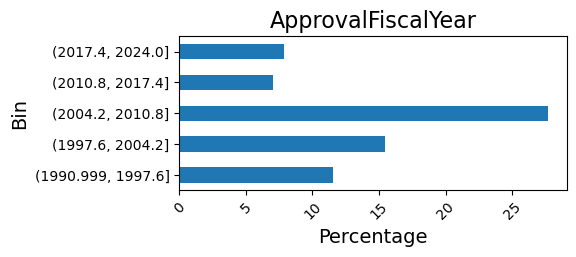

                  bin  order_id Counts  order_id Percentages  \
0  (1990.999, 1997.6]           218673             16.347782   
1    (1997.6, 2004.2]           321796             24.057158   
2    (2004.2, 2010.8]           396724             29.658703   
3    (2010.8, 2017.4]           317173             23.711547   
4    (2017.4, 2024.0]            83265              6.224811   

   NoShow Percentage  
0          11.554696  
1          15.415356  
2          27.715490  
3           7.073427  
4           7.860446   



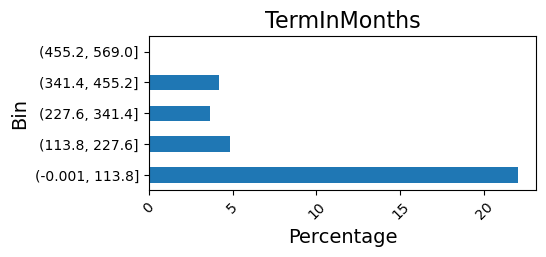

               bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 113.8]           882183             65.951148          21.987501
1   (113.8, 227.6]           268549             20.076464           4.832638
2   (227.6, 341.4]           186750             13.961249           3.669612
3   (341.4, 455.2]              144              0.010765           4.166667
4   (455.2, 569.0]                5              0.000374           0.000000 



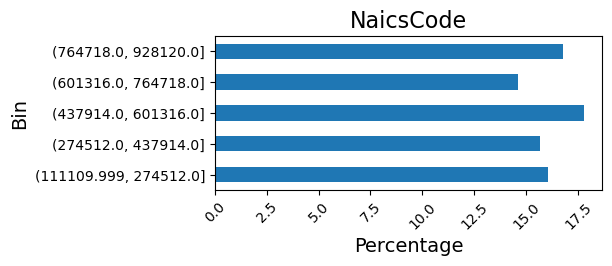

                      bin  order_id Counts  order_id Percentages  \
0  (111109.999, 274512.0]           133736              9.997974   
1    (274512.0, 437914.0]           173125             12.942658   
2    (437914.0, 601316.0]           469610             35.107589   
3    (601316.0, 764718.0]           269219             20.126552   
4    (764718.0, 928120.0]           115973              8.670029   

   NoShow Percentage  
0          16.071963  
1          15.678845  
2          17.775814  
3          14.583666  
4          16.772007   



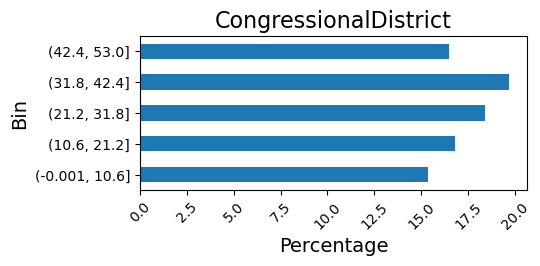

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 10.6]           956981             71.542974          15.351088
1    (10.6, 21.2]           191532             14.318747          16.812856
2    (21.2, 31.8]           104412              7.805740          18.387733
3    (31.8, 42.4]            46007              3.439439          19.668746
4    (42.4, 53.0]            35605              2.661795          16.480831 



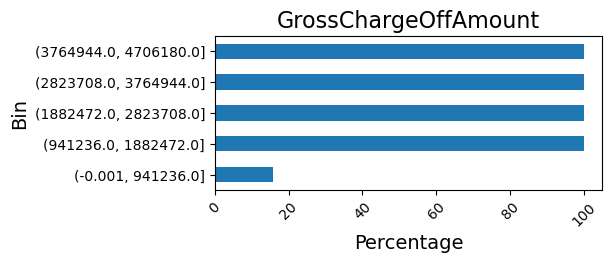

                      bin  order_id Counts  order_id Percentages  \
0      (-0.001, 941236.0]          1335222             99.819905   
1   (941236.0, 1882472.0]             2190              0.163722   
2  (1882472.0, 2823708.0]              168              0.012560   
3  (2823708.0, 3764944.0]               38              0.002841   
4  (3764944.0, 4706180.0]               13              0.000972   

   NoShow Percentage  
0          15.832423  
1         100.000000  
2         100.000000  
3         100.000000  
4         100.000000   



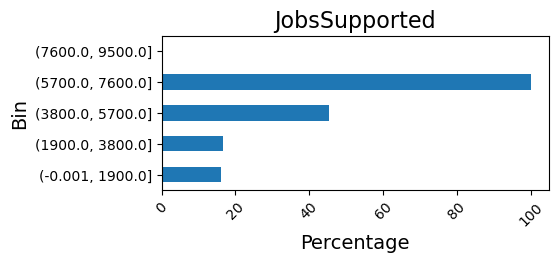

                bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 1900.0]          1337601             99.997757          15.983466
1  (1900.0, 3800.0]                6              0.000449          16.666667
2  (3800.0, 5700.0]               22              0.001645          45.454545
3  (5700.0, 7600.0]                1              0.000075         100.000000
4  (7600.0, 9500.0]                1              0.000075           0.000000 



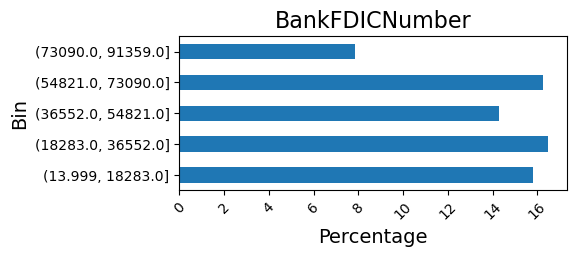

                  bin  order_id Counts  order_id Percentages  \
0   (13.999, 18283.0]           826061             61.755522   
1  (18283.0, 36552.0]           260103             19.445049   
2  (36552.0, 54821.0]                7              0.000523   
3  (54821.0, 73090.0]            99753              7.457438   
4  (73090.0, 91359.0]             3549              0.265320   

   NoShow Percentage  
0          15.802586  
1          16.494235  
2          14.285714  
3          16.273195  
4           7.833192   



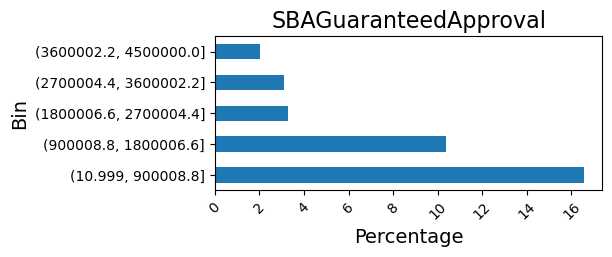

                      bin  order_id Counts  order_id Percentages  \
0      (10.999, 900008.8]          1264011             94.496240   
1   (900008.8, 1800006.6]            32838              2.454937   
2  (1800006.6, 2700004.4]             6183              0.462235   
3  (2700004.4, 3600002.2]             2417              0.180693   
4  (3600002.2, 4500000.0]             1470              0.109896   

   NoShow Percentage  
0          16.555473  
1          10.381266  
2           3.299369  
3           3.103020  
4           2.040816   



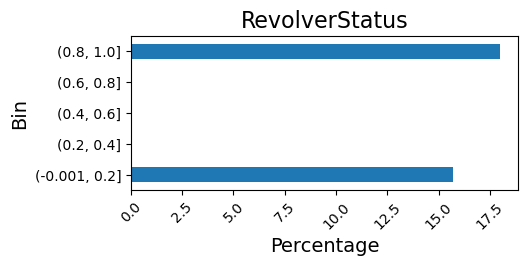

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 0.2]           974508             72.853276          15.719317
1     (0.2, 0.4]                0              0.000000                NaN
2     (0.4, 0.6]                0              0.000000                NaN
3     (0.6, 0.8]                0              0.000000                NaN
4     (0.8, 1.0]           332438             24.852743          17.986813 



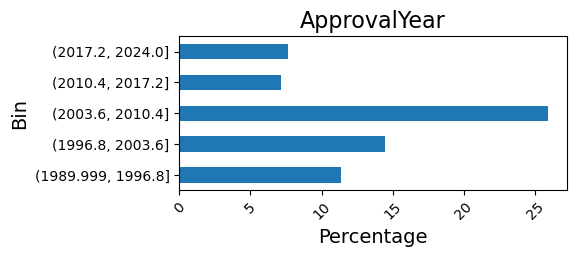

                  bin  order_id Counts  order_id Percentages  \
0  (1989.999, 1996.8]           188894             14.121533   
1    (1996.8, 2003.6]           297411             22.234159   
2    (2003.6, 2010.4]           467853             34.976238   
3    (2010.4, 2017.2]           309367             23.127978   
4    (2017.2, 2024.0]            74106              5.540093   

   NoShow Percentage  
0          11.395809  
1          14.479626  
2          25.938489  
3           7.179176  
4           7.628262   



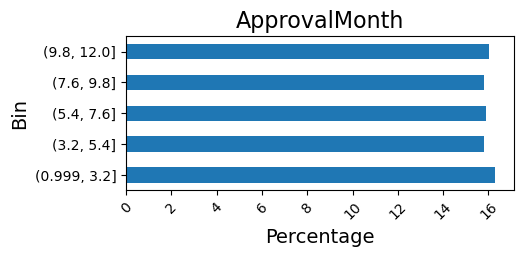

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 3.2]           317970             23.771130          16.290845
1    (3.2, 5.4]           233902             17.486287          15.789519
2    (5.4, 7.6]           229455             17.153834          15.897235
3    (7.6, 9.8]           239433             17.899780          15.816116
4   (9.8, 12.0]           316871             23.688970          16.009354 



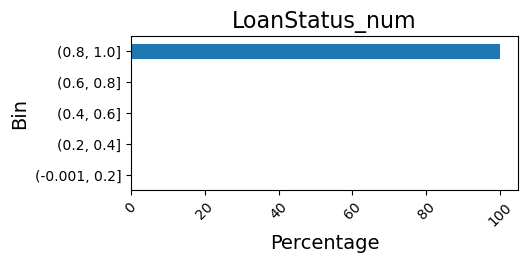

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 0.2]          1123824             84.015995                0.0
1     (0.2, 0.4]                0              0.000000                NaN
2     (0.4, 0.6]                0              0.000000                NaN
3     (0.6, 0.8]                0              0.000000                NaN
4     (0.8, 1.0]           213807             15.984005              100.0 



In [15]:
#Creating bar chart for distribution analysis
def plot_horizontal_bar_chart(df,x):
    try:
        # Convert the DataFrame to a format suitable for plotting
        data = df[['bin', 'NoShow Percentage']].set_index('bin').squeeze()

        # Create the figure and axis objects
        fig, ax = plt.subplots(figsize=(5, 2))

        # Plot the horizontal bar chart
        data.plot(kind='barh', ax=ax)

        # Customize the plot
        ax.set_title(x, fontsize=16)
        ax.set_xlabel('Percentage', fontsize=14)
        ax.set_ylabel('Bin', fontsize=14)

        # Rotate x-axis labels for better visibility
        plt.suptitle('')
        plt.xticks(rotation=45)

        # Display the plot
        plt.show()
    
    except Exception as e:
        print("An error occurred:", e)
        pass  # Continue with the next plot



#Creating dataframes containing 5 bins for the understanding no show distribution using plots for numerical variables
def get_bins_and_no_show_percentage(df, column, target_column, num_bins=5):
    bins = np.linspace(df[column].min(), df[column].max(), num_bins+1)
    df['bin'] = pd.cut(df[column], bins=bins, include_lowest=True,duplicates="drop")
    bin_counts = df['bin'].value_counts()
    bin_percentages = (bin_counts / len(df)) * 100
    no_show_percentages = df.groupby('bin')[target_column].mean() * 100
    result_df = pd.DataFrame({
            'order_id Counts': bin_counts,
            'order_id Percentages': bin_percentages,
            'NoShow Percentage': no_show_percentages
        }).reset_index().rename(columns={'index':column+'_bin'})
        
    return result_df

# # cols=[
# #     'AsOfDate', 
# #       'Program', 
# #       'BorrName', 
# #       'BorrStreet',
# #       'BorrCity',
# #        'BorrState',
# #       'BorrZip', 'CDC_Name', 
# #       'CDC_Street', 'CDC_City',
# #        'CDC_State', 'CDC_Zip',
# #       'ThirdPartyLender_Name',
# #        'ThirdPartyLender_City', 'ThirdPartyLender_State',
#       'ThirdPartyDollars',
#        'GrossApproval', 
# #       'ApprovalDate', 
# #       'ApprovalFiscalYear',
# #        'FirstDisbursementDate',
# #       'DeliveryMethod', 
# #       'Subprogram',
#       'TermInMonths',
# #        'NaicsCode', 
# #       'NaicsDescription', 'FranchiseCode', 'FranchiseName',
# #        'ProjectCounty', 'ProjectState', 'SBADistrictOffice',
# #        'CongressionalDistrict', 'BusinessType', 'BusinessAge',
# #       'LoanStatus',
# #        'PaidInFullDate', 
# #       'ChargeOffDate', 
# #       'GrossChargeOffAmount',
# #        'JobsSupported', 
# #       'ApprovalYear',
# #       'ApprovalMonth'
# # ]

for x in num_cols:
    result = get_bins_and_no_show_percentage(df_filtererd, x, 'LoanStatus_num')
    
    
    plot_horizontal_bar_chart(result,x)
    print(f"{result} \n")

# categorical analysis

In [16]:
df_filtererd['Program'].value_counts()

Program
7A     1306946
504      30685
Name: count, dtype: int64

In [17]:
for x in nonnum_cols:
    print(f'{x} : {df_filtererd[x].nunique()}')

FirstDisbursementDate : 8559
Subprogram : 30
BorrState : 61
ProjectState : 59
BorrName : 1129979
BusinessType : 3
BankState : 63
ApprovalDate : 9760
BankName : 4961
DeliveryMethod : 24
ProjectCounty : 1937
BankStreet : 5578
BorrCity : 41177
NaicsDescription : 1335
LoanStatus : 2
BankZip : 7371
BankCity : 3184
BorrStreet : 1202546
Program : 2
SBADistrictOffice : 84


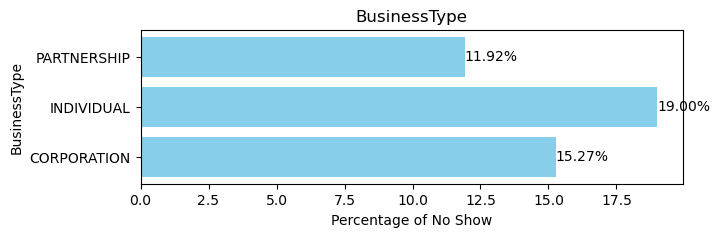

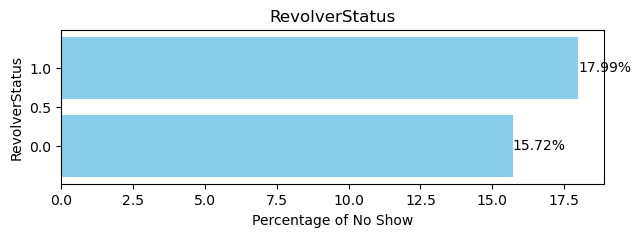

In [18]:
#Creating plots with categories to understand distrutions of no shows for categorical variables

def plot_no_show_percentage(categorical_column, target_column, data, category_order=None):
    try:
        # Group data by the categorical column and calculate the percentage of 'no show' class (1) for each category
        grouped = data.groupby(categorical_column)[target_column].mean() * 100

        # If category_order is provided, reorder the categories
        if category_order:
            grouped = grouped.reindex(category_order)

        # Create the plot
        plt.figure(figsize=(7, 2))
        bars = plt.barh(grouped.index, grouped.values, color='skyblue')
        plt.xlabel('Percentage of No Show')
        plt.ylabel(categorical_column)
        plt.title(f'{categorical_column}')
    #     plt.gca().invert_yaxis()  # Invert y-axis to have the highest category at the top

        # Add labels to the bars
        for bar in bars:
            plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%', 
                     va='center', ha='left')

        plt.show()
    except Exception as e:
        print("An error occurred:", e)
        pass  # Continue with the next plot

nonnum_cols=[
#     'BankZip',
#  'BorrName',
#  'NaicsDescription',
#  'SBADistrictOffice',
#  'BankState',
#  'BankStreet',
#  'BankCity',
#  'FirstDisbursementDate',
#  'ApprovalDate',
#  'BorrStreet',
#  'ProjectState',
#  'Program',
#  'ProjectCounty',
#  'DeliveryMethod',
#  'BorrState',
#  'LoanStatus',
#  'BorrCity',
 'BusinessType',
#  'BankName',
#  'Subprogram',
#     'ApprovalMonth',
#     'ApprovalYear',
    'RevolverStatus'
]    



# Example usage:
# Assume 'data' is your DataFrame containing the data
# Assume 'categorical_column' is the categorical column
# Assume 'target_column' is the target column containing 'no show' (1) and 'show' (0) classes
# plot_no_show_percentage(categorical_column, target_column, data, category_order=None)
for x in nonnum_cols:
    plot_no_show_percentage(x,'LoanStatus_num',df_filtererd)
# plot_no_show_percentage('is_exclusive_lead','LoanStatus_num',df_filtererd)


In [19]:
 def categorical_patt(df_filtererd,x):
    df_appyear=pd.DataFrame(df_filtererd.groupby(x).agg({'LoanStatus_num':'count'})['LoanStatus_num'])
    df_appyear1=pd.DataFrame(df_filtererd.groupby(x).agg({'LoanStatus_num':'sum'})['LoanStatus_num'])
    df_appyear_final=pd.merge(df_appyear,df_appyear1,on=x,how='left')
    df_appyear_final.reset_index(inplace=True)
    df_appyear_final['Default_perc']=(df_appyear_final['LoanStatus_num_y']/df_appyear_final['LoanStatus_num_x'])*100
    df_appyear_final.rename(columns={'LoanStatus_num_x':'Total_loans_no','LoanStatus_num_y':'Total_default_loans_no'},inplace=True)
    return df_appyear_final.sort_values('Default_perc',ascending=False)

appyear_df=categorical_patt(df_filtererd,'ApprovalYear')
appyear_df

,ApprovalYear,Total_loans_no,Total_default_loans_no,Default_perc
17,2007,84869,32089,37.810037
16,2006,88048,30025,34.100718
18,2008,49981,13505,27.020268
15,2005,81816,21934,26.808937
14,2004,74447,14828,19.917525
13,2003,63424,10364,16.340817
10,2000,36844,5532,15.014656
0,1990,3525,528,14.978723
9,1999,37323,5386,14.430780
11,2001,38218,5464,14.296928


In [20]:
pro_df=categorical_patt(df_filtererd,'Program')
pro_df

,Program,Total_loans_no,Total_default_loans_no,Default_perc
1,7A,1306946,212981,16.296083
0,504,30685,826,2.691869


In [21]:
del_df=categorical_patt(df_filtererd,'DeliveryMethod')
del_df

,DeliveryMethod,Total_loans_no,Total_default_loans_no,Default_perc
6,COMM EXPRS,43102,17436,40.452879
23,Y2K,16,6,37.500000
14,INTER TRDE,4290,1192,27.785548
22,USCAIP,118,28,23.728814
16,PATRIOT EX,9553,1942,20.328693
20,SBA EXPRES,556963,99468,17.858996
4,CA,3654,594,16.256158
12,EXPRES EXP,2294,334,14.559721
15,OTH 7A,296876,41874,14.104879
18,PLP,306318,42120,13.750416


In [22]:
# businessage_df=categorical_patt(df_filtererd,'BusinessAge')
# businessage_df

In [23]:
appmonth_df=categorical_patt(df_filtererd,'ApprovalMonth')
appmonth_df

,ApprovalMonth,Total_loans_no,Total_default_loans_no,Default_perc
9,10,104338,17113,16.401503
2,3,122727,20040,16.328925
1,2,99123,16156,16.298942
0,1,96120,15604,16.233874
7,8,116334,18877,16.226555
10,11,102775,16666,16.216006
5,6,116299,18786,16.153191
4,5,115309,18294,15.865197
3,4,118593,18638,15.715936
6,7,113156,17691,15.634169


In [24]:
bussinesst_df=categorical_patt(df_filtererd,'BusinessType')
bussinesst_df

,BusinessType,Total_loans_no,Total_default_loans_no,Default_perc
1,INDIVIDUAL,296754,56374,18.996880
0,CORPORATION,995358,152007,15.271591
2,PARTNERSHIP,45458,5420,11.923094


In [25]:
# P3_df=categorical_patt(df_filtererd,'ThirdPartyLender_Name')
# P3_df

In [26]:
# P3state_df=categorical_patt(df_filtererd,'ThirdPartyLender_State')
# P3state_df

In [27]:
Pstate_df=categorical_patt(df_filtererd,'ProjectState')
Pstate_df

,ProjectState,Total_loans_no,Total_default_loans_no,Default_perc
3,AS,19,6,31.578947
10,FL,62751,14942,23.811573
38,NV,10814,2453,22.683558
12,GA,33737,6998,20.742805
8,DC,2327,469,20.154706
17,IL,43616,8580,19.671680
1,AL,10592,2014,19.014350
49,TN,13446,2549,18.957311
36,NJ,36757,6790,18.472672
57,WV,4660,860,18.454936


In [28]:
Pcountry_df=categorical_patt(df_filtererd,'ProjectCounty')
Pcountry_df

,ProjectCounty,Total_loans_no,Total_default_loans_no,Default_perc
581,ESMERALDA,1,1,100.000000
1117,MCMULLEN,1,1,100.000000
609,FISHER,10,7,70.000000
520,DODDRIDGE,6,4,66.666667
1752,TROUSDALE,6,4,66.666667
674,GLASCOCK,3,2,66.666667
1622,SLOPE,3,2,66.666667
375,CLIFTON FORGE,3,2,66.666667
451,CROWLEY,3,2,66.666667
322,CHARLTON,8,5,62.500000


In [29]:
sp_df=categorical_patt(df_filtererd,'Subprogram')
sp_df

,Subprogram,Total_loans_no,Total_default_loans_no,Default_perc
4,Community Express,43101,17435,40.451498
15,"International Trade - Sec, 7(a) (16)",4928,1222,24.797078
17,Patriot Express,9560,1945,20.345188
10,FA$TRK (Small Loan Express),559227,99802,17.846420
6,"Defense Loans and Technical Assistance, Funded...",222,37,16.666667
3,Community Advantage Initiative,3670,595,16.212534
18,Pollution Control Guaranteed Loans - Sec. 7(a)...,31,5,16.129032
29,Y2K Loan,86,12,13.953488
13,Guaranty,638681,87806,13.748021
14,Gulf Opportunity,2798,367,13.116512


In [30]:
#  'BankStreet',
#  'BankName',
#  'BorrCity',
#  'BorrZip',
#  'ApprovalFiscalYear',
# #  'ApprovalYear',
# #  'BankZip',
# #  'BankCity',
#  'NaicsDescription',
#  'BankState',
#  'DeliveryMethod',
#  'Subprogram'
bs_df=categorical_patt(df_filtererd,'BankStreet')
bs_df

,BankStreet,Total_loans_no,Total_default_loans_no,Default_perc
394,1021 E Hawthorne Rd,1,1,100.0
1900,19860 S LaGrange Rd,1,1,100.0
3249,3200 Southwest Frwy #950,1,1,100.0
2163,2023 Gold Canyon Dr,1,1,100.0
2172,203 S 6th St,1,1,100.0
...,...,...,...,...
3806,414 Church St,7,0,0.0
2071,201 N Wilbur,1,0,0.0
3809,4140 W I 40 Service Rd,9,0,0.0
858,118 S Sandusky Ave,2,0,0.0


In [31]:
bn_df=categorical_patt(df_filtererd,'BankName')
bn_df

,BankName,Total_loans_no,Total_default_loans_no,Default_perc
2876,Minority Investment Development Corp.,4,4,100.000000
1943,First State Bank of Decatur,1,1,100.000000
3776,"Southside Bancshares, Inc.",2,2,100.000000
1085,"Commercial Financial Services, Inc.",1,1,100.000000
2387,Hyden Citizens Bank,2,2,100.000000
1420,Eureka Savings Bank,1,1,100.000000
1073,"Commercefirst Bancorp, Inc.",1,1,100.000000
3423,Putnam 1st Mercantile Bank,2,2,100.000000
3409,Prosperan Bank,1,1,100.000000
267,Astra Financial Corporation,1,1,100.000000


In [32]:
borc_df=categorical_patt(df_filtererd,'BorrCity')
borc_df

,BorrCity,Total_loans_no,Total_default_loans_no,Default_perc
8996,DUNNWOODY,1,1,100.0
7354,Charokee,1,1,100.0
38344,WATBESBORO,1,1,100.0
15988,Headland,2,2,100.0
21798,MILFORN,1,1,100.0
...,...,...,...,...
17947,Keewatin,2,0,0.0
17946,Keesler AFB,1,0,0.0
17945,Keeseville,4,0,0.0
17944,Keenesburg,1,0,0.0


In [33]:
borz_df=categorical_patt(df_filtererd,'BorrZip')
borz_df

,BorrZip,Total_loans_no,Total_default_loans_no,Default_perc
18475,51015,1,1,100.0
13241,36524,1,1,100.0
13135,36112,1,1,100.0
13140,36120,1,1,100.0
13141,36121,1,1,100.0
...,...,...,...,...
24121,67457,2,0,0.0
11258,31557,3,0,0.0
11257,31556,1,0,0.0
11253,31551,1,0,0.0


In [34]:
naics_df=categorical_patt(df_filtererd,'NaicsDescription')
naics_df

,NaicsDescription,Total_loans_no,Total_default_loans_no,Default_perc
275,Courts,1,1,100.000000
1240,Tire Cord and Tire Fabric Mills,1,1,100.000000
703,Motor Home Manufacturing,9,6,66.666667
1062,Regulation and Administration of Transportatio...,8,5,62.500000
1036,Public Finance Activities,12,7,58.333333
5,Administration of General Economic Programs,8,4,50.000000
487,Grantmaking Foundations,4,2,50.000000
278,Credit Card Issuing,4,2,50.000000
600,Laminated Aluminum Foil Manufacturing for Flex...,8,4,50.000000
200,Clay and Ceramic and Refractory Minerals Mining,4,2,50.000000


In [35]:
banks_df=categorical_patt(df_filtererd,'BankState')
banks_df

,BankState,Total_loans_no,Total_default_loans_no,Default_perc
16,Gu,2,1,50.000000
50,SC,9878,3234,32.739421
56,VA,36090,11742,32.535328
39,NJ,27486,6360,23.139053
35,NC,123284,27270,22.119659
6,CA,109403,23532,21.509465
49,RI,47473,9051,19.065574
55,UT,40920,7126,17.414467
53,TX,48218,8186,16.977063
61,WV,2289,379,16.557449


In [36]:
#Checking correlation between different variables
def highlight_values(df):
   
    styled_df = df.style.format("{:.1f}")
    
    
    # Define a function to apply the highlight condition
    def highlight_condition(value):
        if value > 75 or value < -75:
            return 'background-color: lightsalmon'
        else:
            return ''
    
    # Apply the highlight condition to all columns
    highlighted_df = styled_df.applymap(highlight_condition)
    
    return highlighted_df

# cols=['ThirdPartyDollars',
#       'TermInMonths',
#       'GrossApproval',
#      'ApprovalYear',
# #      'BusinessAge'
#      ]

highlighted_df = highlight_values(df_filtererd[num_cols].corr()*100)
print("\nHighlighted Correlation DataFrame:")
highlighted_df


Highlighted Correlation DataFrame:


,AsOfDate,BorrZip,GrossApproval,ApprovalFiscalYear,TermInMonths,NaicsCode,CongressionalDistrict,GrossChargeOffAmount,JobsSupported,BankFDICNumber,SBAGuaranteedApproval,RevolverStatus,ApprovalYear,ApprovalMonth,LoanStatus_num
AsOfDate,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BorrZip,nan,100.0,8.1,-1.0,13.6,-0.7,27.8,0.8,1.7,-15.6,8.0,-3.3,-1.0,0.4,-0.1
GrossApproval,nan,8.1,100.0,14.7,47.9,2.4,5.5,18.2,15.7,13.3,99.2,-21.7,14.6,2.4,-7.2
ApprovalFiscalYear,nan,-1.0,14.7,100.0,-0.5,2.4,0.6,-0.4,12.0,11.4,12.2,25.5,99.8,1.8,-4.4
TermInMonths,nan,13.6,47.9,-0.5,100.0,10.8,7.9,-0.8,2.7,8.2,47.4,-29.4,-0.6,2.1,-26.4
NaicsCode,nan,-0.7,2.4,2.4,10.8,100.0,0.5,1.1,2.6,3.7,2.6,-10.5,2.4,1.2,-0.2
CongressionalDistrict,nan,27.8,5.5,0.6,7.9,0.5,100.0,1.0,1.5,-2.3,4.8,2.4,0.6,0.5,3.1
GrossChargeOffAmount,nan,0.8,18.2,-0.4,-0.8,1.1,1.0,100.0,4.6,2.1,18.5,-6.6,-0.4,0.4,44.6
JobsSupported,nan,1.7,15.7,12.0,2.7,2.6,1.5,4.6,100.0,2.7,14.7,0.4,12.0,0.7,-0.6
BankFDICNumber,nan,-15.6,13.3,11.4,8.2,3.7,-2.3,2.1,2.7,100.0,13.6,-8.6,11.4,0.6,-1.1


# Feature engineering

In [37]:
df_filtererd.isnull().sum()/len(df)*100


AsOfDate                 0.000000
Program                  0.000000
BorrName                 0.001521
BorrStreet               0.005401
BorrCity                 0.001206
BorrState                0.001363
BorrZip                  0.000000
GrossApproval            0.001416
ApprovalDate             0.000000
ApprovalFiscalYear       0.000000
FirstDisbursementDate    0.157981
DeliveryMethod           0.001416
Subprogram               0.012846
TermInMonths             0.000000
NaicsCode                9.226525
NaicsDescription         9.262231
ProjectCounty            0.029939
ProjectState             0.002779
SBADistrictOffice        0.001206
CongressionalDistrict    0.162228
BusinessType             0.003198
LoanStatus               0.000000
GrossChargeOffAmount     0.000000
JobsSupported            0.000000
BankName                 1.608906
BankFDICNumber           7.768364
BankStreet               1.673923
BankCity                 1.673870
BankState                1.676125
BankZip       

## Missing value treatment with mode

In [38]:
df_filtererd_cleaned=df_filtererd.copy()
for x in df_filtererd.columns:
    mode = df_filtererd[x].mode()[0]
    df_filtererd_cleaned[x].fillna(mode, inplace=True)


In [39]:
df_filtererd_cleaned

,AsOfDate,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,GrossApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,Subprogram,TermInMonths,NaicsCode,NaicsDescription,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,LoanStatus,GrossChargeOffAmount,JobsSupported,BankName,BankFDICNumber,BankStreet,BankCity,BankState,BankZip,SBAGuaranteedApproval,RevolverStatus,ApprovalYear,ApprovalMonth,LoanStatus_num,bin
0,20240331,504,Turning Brook,300 & 400 Oxbow Dr 100 Villa,Alpena,MI,49707,1248000.0,2009-10-02,2010,01/12/2011,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,623312.0,Homes for the Elderly,ALPENA,MI,MICHIGAN DISTRICT OFFICE,1.0,CORPORATION,PIF,0,14,"Wells Fargo Bank, National Association",3511.0,101 N Philips Ave,COLUMBUS,OH,28202.0,25000.0,0.0,2009,10,0,"(-0.001, 0.2]"
2,20240331,504,"Rocket Express, LLC",1122 Blue Laker Boulevard Nort,Twin falls,ID,83301,1594000.0,2009-10-02,2010,10/13/2010,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,811192.0,Car Washes,TWIN FALLS,ID,BOISE DISTRICT OFFICE,2.0,CORPORATION,PIF,0,8,"Wells Fargo Bank, National Association",3511.0,101 N Philips Ave,COLUMBUS,OH,28202.0,25000.0,0.0,2009,10,0,"(-0.001, 0.2]"
3,20240331,504,Martin Harper P.C.,3 E. Ramona Avenue.,Colorado springs,CO,80905,127000.0,2009-10-02,2010,01/12/2011,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,541211.0,Offices of Certified Public Accountants,EL PASO,CO,COLORADO DISTRICT OFFICE,5.0,CORPORATION,PIF,0,1,"Wells Fargo Bank, National Association",3511.0,101 N Philips Ave,COLUMBUS,OH,28202.0,25000.0,0.0,2009,10,0,"(-0.001, 0.2]"
4,20240331,504,"Shield Security Systems, L.L.C",7456 West 5th Avenue.,Lakewood,CO,80226,757000.0,2009-10-02,2010,06/16/2010,PCLP,Sec. 504 - Premier Certified Lender Program,240,332510.0,Hardware Manufacturing,JEFFERSON,CO,COLORADO DISTRICT OFFICE,1.0,CORPORATION,PIF,0,40,"Wells Fargo Bank, National Association",3511.0,101 N Philips Ave,COLUMBUS,OH,28202.0,25000.0,0.0,2009,10,0,"(-0.001, 0.2]"
5,20240331,504,KT&apos;s Bowling Lanes,1501 S. Washington Avenue.,Emmett,ID,83617,111000.0,2009-10-02,2010,11/17/2010,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,713950.0,Bowling Centers,GEM,ID,BOISE DISTRICT OFFICE,1.0,CORPORATION,PIF,0,10,"Wells Fargo Bank, National Association",3511.0,101 N Philips Ave,COLUMBUS,OH,28202.0,25000.0,0.0,2009,10,0,"(-0.001, 0.2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888830,20240331,7A,Gualtieri's Bakery LLC,420 E 9TH ST,ROCHESTER,IN,46975,13100.0,2023-12-21,2024,12/27/2023,SBA EXPRES,FA$TRK (Small Loan Express),59,311811.0,Retail Bakeries,FULTON,IN,INDIANA DISTRICT OFFICE,2.0,CORPORATION,PIF,0,1,1st Source Bank,9087.0,100 N Michigan St,SOUTH BEND,IN,46601,6550.0,0.0,2023,12,0,"(-0.001, 0.2]"
1889060,20240331,7A,All Star Power Excavation LLC,833 N. BRYS DR,GROSSE POINTE WOODS,MI,48236,212100.0,2023-12-21,2024,12/28/2023,SBA EXPRES,FA$TRK (Small Loan Express),84,488490.0,Other Support Activities for Road Transportation,WAYNE,MI,MICHIGAN DISTRICT OFFICE,12.0,CORPORATION,PIF,0,0,"Bank of America, National Association",3510.0,"100 N Tryon St, Ste 170",CHARLOTTE,NC,28202,106050.0,0.0,2023,12,0,"(-0.001, 0.2]"
1889789,20240331,7A,SSIT Inc,5201 GREAT AMERICA PKWY SUIT,SANTA CLARA,CA,95054,300000.0,2023-12-27,2024,01/05/2024,SBA EXPRES,FA$TRK (Small Loan Express),120,541511.0,Custom Computer Programming Services,SANTA CLARA,CA,SAN FRANCISCO DISTRICT OFFICE,17.0,CORPORATION,PIF,0,20,"Bank of America, National Association",3510.0,"100 N Tryon St, Ste 170",CHARLOTTE,NC,28202,150000.0,0.0,2023,12,0,"(-0.001, 0.2]"
1893421,20240331,7A,H Rivero MD PA,7980 CORAL WAY,MIAMI,FL,33155,300000.0,2024-01-21,2024,01/23/2024,SBA EXPRES,FA$TRK (Small Loan Express),84,621111.0,Offices of Physicians (except Mental Health Sp...,MIAMI-DADE,FL,SOUTH FLORIDA DISTRICT OFFICE,27.0,CORPORATION,PIF,0,2

In [40]:
df_filtererd_cleaned.isnull().sum()/len(df)*100


AsOfDate                 0.0
Program                  0.0
BorrName                 0.0
BorrStreet               0.0
BorrCity                 0.0
BorrState                0.0
BorrZip                  0.0
GrossApproval            0.0
ApprovalDate             0.0
ApprovalFiscalYear       0.0
FirstDisbursementDate    0.0
DeliveryMethod           0.0
Subprogram               0.0
TermInMonths             0.0
NaicsCode                0.0
NaicsDescription         0.0
ProjectCounty            0.0
ProjectState             0.0
SBADistrictOffice        0.0
CongressionalDistrict    0.0
BusinessType             0.0
LoanStatus               0.0
GrossChargeOffAmount     0.0
JobsSupported            0.0
BankName                 0.0
BankFDICNumber           0.0
BankStreet               0.0
BankCity                 0.0
BankState                0.0
BankZip                  0.0
SBAGuaranteedApproval    0.0
RevolverStatus           0.0
ApprovalYear             0.0
ApprovalMonth            0.0
LoanStatus_num

In [41]:
df_filtererd_cleaned=df_filtererd_cleaned[cols]


## Target Encoding categorical data

In [42]:
df_filtererd_cleaned['BorrZip'] = df_filtererd_cleaned['BorrZip'].astype(object)
df_filtererd_cleaned['BankZip'] = df_filtererd_cleaned['BorrZip'].astype(object)
df_filtererd_cleaned['ApprovalYear'] = df_filtererd_cleaned['BorrZip'].astype(object)
df_filtererd_cleaned['ApprovalFiscalYear'] = df_filtererd_cleaned['BorrZip'].astype(object)



In [43]:
nonnum_cols2=df_filtererd_cleaned.select_dtypes(exclude='number').columns
len(nonnum_cols2)

23

In [44]:
cols2=df_filtererd_cleaned.select_dtypes(include='number').columns
len(cols2)

12

In [45]:
# Calculate means
df_filtererd_cleaned_enc=df_filtererd_cleaned.copy()
for x in nonnum_cols2:
    mean_encoded = df_filtererd_cleaned_enc.groupby(x)['LoanStatus_num'].mean()

    # Map the means to the original data
    df_filtererd_cleaned_enc[x] = df_filtererd_cleaned_enc[x].map(mean_encoded)


In [46]:
df_filtererd_cleaned_enc

,AsOfDate,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,GrossApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,Subprogram,TermInMonths,NaicsCode,NaicsDescription,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,LoanStatus,GrossChargeOffAmount,JobsSupported,BankName,BankFDICNumber,BankStreet,BankCity,BankState,BankZip,SBAGuaranteedApproval,RevolverStatus,ApprovalYear,ApprovalMonth,LoanStatus_num
0,20240331,0.026919,0.0,0.0,0.142857,0.159146,0.152542,1248000.0,0.080745,0.152542,0.045455,0.020732,0.026588,240,623312.0,0.061719,0.178082,0.159423,0.159324,1.0,0.152713,0.0,0,14,0.116045,3511.0,0.115726,0.132715,0.132524,0.152542,25000.0,0.0,0.152542,10,0
2,20240331,0.026919,0.0,0.0,0.000000,0.124935,0.107895,1594000.0,0.080745,0.107895,0.048851,0.040055,0.026588,240,811192.0,0.129293,0.117647,0.125490,0.126907,2.0,0.152713,0.0,0,8,0.116045,3511.0,0.115726,0.132715,0.132524,0.107895,25000.0,0.0,0.107895,10,0
3,20240331,0.026919,0.0,0.0,0.011905,0.153966,0.081967,127000.0,0.080745,0.081967,0.045455,0.040055,0.026588,240,541211.0,0.110341,0.163944,0.154217,0.154252,5.0,0.152713,0.0,0,1,0.116045,3511.0,0.115726,0.132715,0.132524,0.081967,25000.0,0.0,0.081967,10,0
4,20240331,0.026919,0.0,0.0,0.115768,0.153966,0.197044,757000.0,0.080745,0.197044,0.037453,0.000000,0.000000,240,332510.0,0.127273,0.174090,0.154217,0.154252,1.0,0.152713,0.0,0,40,0.116045,3511.0,0.115726,0.132715,0.132524,0.197044,25000.0,0.0,0.197044,10,0
5,20240331,0.026919,0.0,0.0,0.066667,0.124935,0.177419,111000.0,0.080745,0.177419,0.050125,0.040055,0.026588,240,713950.0,0.149716,0.201493,0.125490,0.126907,1.0,0.152713,0.0,0,10,0.116045,3511.0,0.115726,0.132715,0.132524,0.177419,25000.0,0.0,0.177419,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888830,20240331,0.162961,0.0,0.0,0.146037,0.147087,0.047619,13100.0,0.000000,0.047619,0.000000,0.178581,0.178464,59,311811.0,0.171687,0.196239,0.147278,0.147318,2.0,0.152713,0.0,0,1,0.074257,9087.0,0.074257,0.073457,0.102793,0.047619,6550.0,0.0,0.047619,12,0
1889060,20240331,0.162961,0.0,0.0,0.083333,0.159146,0.171429,212100.0,0.000000,0.171429,0.000000,0.178581,0.178464,84,488490.0,0.159649,0.233854,0.159423,0.159324,12.0,0.152713,0.0,0,0,0.263106,3510.0,0.263498,0.236876,0.221197,0.171429,106050.0,0.0,0.171429,12,0
1889789,20240331,0.162961,0.0,0.0,0.203518,0.170211,0.138514,300000.0,0.000000,0.138514,0.000000,0.178581,0.178464,120,541511.0,0.128391,0.141078,0.170229,0.141241,17.0,0.152713,0.0,0,20,0.263106,3510.0,0.263498,0.236876,0.221197,0.138514,150000.0,0.0,0.138514,12,0
1893421,20240331,0.162961,0.0,0.0,0.316467,0.238719,0.306358,300000.0,0.000000,0.306358,0.000000,0.178581,0.178464,84,621111.0,0.071911,0.321514,0.238116,0.245311,27.0,0.152713,0.0,0,2,0.196042,628.0,0.196042,0.132715,0.132524,0.306358,150000.0,0.0,0.306358,1,0


In [47]:
df_filtererd_cleaned_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337631 entries, 0 to 1894940
Data columns (total 35 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   AsOfDate               1337631 non-null  int64  
 1   Program                1337631 non-null  float64
 2   BorrName               1337631 non-null  float64
 3   BorrStreet             1337631 non-null  float64
 4   BorrCity               1337631 non-null  float64
 5   BorrState              1337631 non-null  float64
 6   BorrZip                1337631 non-null  float64
 7   GrossApproval          1337631 non-null  float64
 8   ApprovalDate           1337631 non-null  float64
 9   ApprovalFiscalYear     1337631 non-null  float64
 10  FirstDisbursementDate  1337631 non-null  float64
 11  DeliveryMethod         1337631 non-null  float64
 12  Subprogram             1337631 non-null  float64
 13  TermInMonths           1337631 non-null  int64  
 14  NaicsCode              

## New features


In [48]:
df_filtererd_cleaned_enc['SBAAPP/GrossAPP'] = df_filtererd_cleaned_enc['SBAGuaranteedApproval']/ df_filtererd_cleaned_enc['GrossApproval']
df_filtererd_cleaned_enc

,AsOfDate,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,GrossApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,Subprogram,TermInMonths,NaicsCode,NaicsDescription,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,LoanStatus,GrossChargeOffAmount,JobsSupported,BankName,BankFDICNumber,BankStreet,BankCity,BankState,BankZip,SBAGuaranteedApproval,RevolverStatus,ApprovalYear,ApprovalMonth,LoanStatus_num,SBAAPP/GrossAPP
0,20240331,0.026919,0.0,0.0,0.142857,0.159146,0.152542,1248000.0,0.080745,0.152542,0.045455,0.020732,0.026588,240,623312.0,0.061719,0.178082,0.159423,0.159324,1.0,0.152713,0.0,0,14,0.116045,3511.0,0.115726,0.132715,0.132524,0.152542,25000.0,0.0,0.152542,10,0,0.020032
2,20240331,0.026919,0.0,0.0,0.000000,0.124935,0.107895,1594000.0,0.080745,0.107895,0.048851,0.040055,0.026588,240,811192.0,0.129293,0.117647,0.125490,0.126907,2.0,0.152713,0.0,0,8,0.116045,3511.0,0.115726,0.132715,0.132524,0.107895,25000.0,0.0,0.107895,10,0,0.015684
3,20240331,0.026919,0.0,0.0,0.011905,0.153966,0.081967,127000.0,0.080745,0.081967,0.045455,0.040055,0.026588,240,541211.0,0.110341,0.163944,0.154217,0.154252,5.0,0.152713,0.0,0,1,0.116045,3511.0,0.115726,0.132715,0.132524,0.081967,25000.0,0.0,0.081967,10,0,0.196850
4,20240331,0.026919,0.0,0.0,0.115768,0.153966,0.197044,757000.0,0.080745,0.197044,0.037453,0.000000,0.000000,240,332510.0,0.127273,0.174090,0.154217,0.154252,1.0,0.152713,0.0,0,40,0.116045,3511.0,0.115726,0.132715,0.132524,0.197044,25000.0,0.0,0.197044,10,0,0.033025
5,20240331,0.026919,0.0,0.0,0.066667,0.124935,0.177419,111000.0,0.080745,0.177419,0.050125,0.040055,0.026588,240,713950.0,0.149716,0.201493,0.125490,0.126907,1.0,0.152713,0.0,0,10,0.116045,3511.0,0.115726,0.132715,0.132524,0.177419,25000.0,0.0,0.177419,10,0,0.225225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888830,20240331,0.162961,0.0,0.0,0.146037,0.147087,0.047619,13100.0,0.000000,0.047619,0.000000,0.178581,0.178464,59,311811.0,0.171687,0.196239,0.147278,0.147318,2.0,0.152713,0.0,0,1,0.074257,9087.0,0.074257,0.073457,0.102793,0.047619,6550.0,0.0,0.047619,12,0,0.500000
1889060,20240331,0.162961,0.0,0.0,0.083333,0.159146,0.171429,212100.0,0.000000,0.171429,0.000000,0.178581,0.178464,84,488490.0,0.159649,0.233854,0.159423,0.159324,12.0,0.152713,0.0,0,0,0.263106,3510.0,0.263498,0.236876,0.221197,0.171429,106050.0,0.0,0.171429,12,0,0.500000
1889789,20240331,0.162961,0.0,0.0,0.203518,0.170211,0.138514,300000.0,0.000000,0.138514,0.000000,0.178581,0.178464,120,541511.0,0.128391,0.141078,0.170229,0.141241,17.0,0.152713,0.0,0,20,0.263106,3510.0,0.263498,0.236876,0.221197,0.138514,150000.0,0.0,0.138514,12,0,0.500000
1893421,20240331,0.162961,0.0,0.0,0.316467,0.238719,0.306358,300000.0,0.000000,0.306358,0.000000,0.178581,0.178464,84,621111.0,0.071911,0.321514,0.238116,0.245311,27.0,0.152713,0.0,0,2,0.196042,628.0,0.196042,0.132715,0.132524,0.306358,150000.0,0.0,0.306358,1,0,0.500000


# Feature selection

In [49]:
import pandas as pd

# Calculate information value

def calculate_iv(data, target,bins=10,show_woe=False):
    new_df,woe_df=pd.DataFrame(),pd.DataFrame()
    cols=data.columns
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x=pd.qcut(data[ivars],bins,duplicates='drop')
            d0=pd.DataFrame({'x':binned_x,'y':data[target]})
        else:
            d0=pd.DataFrame({'x':data[ivars],'y':data[target]})
            
        d=d0.groupby("x",as_index=False).agg({"y":["count","sum"]})
        d.columns=["Cutoff","N","Events"]
        
        d["% of Events"]=np.maximum(d['Events'],0.5)/d['Events'].sum()
        
        d['Non-Events']=d['N']-d["Events"]
        d['% of Non-Events']=np.maximum(d['Non-Events'],0.5)/d['Non-Events'].sum()
        
        d['WOE']=np.log(d["% of Events"]/d["% of Non-Events"])
        d["IV"]=d["WOE"]*(d["% of Events"]-d["% of Non-Events"])
        d.insert(loc=0,column="Variable",value=ivars)
        #print(f"information value of {ivars} is {str(round(d['IV'].sum(),6))}")
        
        temp=pd.DataFrame({"Variable":[ivars],"IV":[d['IV'].sum()]},columns=["Variable","IV"])
        new_df=pd.concat([new_df,temp],axis=0)
        woe_df=pd.concat([woe_df,d],axis=0)
        
        if show_woe==True:
            print(d)
    return new_df,woe_df
        

new_df,woe_df = calculate_iv(df_filtererd_cleaned_enc, 'LoanStatus_num',bins=10,show_woe=False)


In [50]:
new_df=new_df.sort_values(by='IV',ascending=False).reset_index()
new_df
# new_df[(new_df["IV"]>=0.1)|(new_df["IV"]<=0.5 )]

,index,Variable,IV
0,0,LoanStatus,27.591334
1,0,GrossChargeOffAmount,9.471260
2,0,TermInMonths,1.138845
3,0,ApprovalDate,0.553607
4,0,FirstDisbursementDate,0.536786
5,0,BankStreet,0.382476
6,0,BankName,0.380568
7,0,BorrCity,0.353513
8,0,BorrZip,0.338042
9,0,ApprovalFiscalYear,0.338042


## threshold
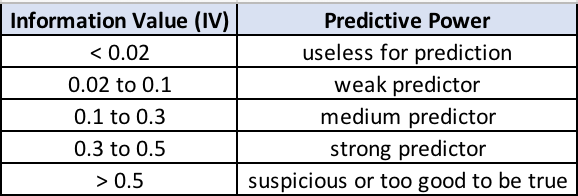

In [51]:
#good and medium predictors
new_df1=new_df.drop('index',axis=1)
final_cols=list(new_df1[(new_df1["IV"]>=0.1)&(new_df1["IV"]<=0.5 )]['Variable'])

In [52]:
final_cols

['BankStreet',
 'BankName',
 'BorrCity',
 'BorrZip',
 'ApprovalFiscalYear',
 'ApprovalYear',
 'BankZip',
 'BankCity',
 'NaicsDescription',
 'BankState',
 'DeliveryMethod',
 'Subprogram']

In [53]:
dfhsd

NameError: name 'dfhsd' is not defined

In [54]:
final_cols=[
    'BankStreet',
 'BankName',
 'BorrCity',
 'BorrZip',
 'ApprovalFiscalYear',
 'ApprovalYear',
 'BankZip',
 'BankCity',
 'NaicsDescription',
 'BankState',
 'DeliveryMethod',
 'Subprogram']

In [55]:
df_filtererd_cleaned_enc[final_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337631 entries, 0 to 1894940
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   BankStreet          1337631 non-null  float64
 1   BankName            1337631 non-null  float64
 2   BorrCity            1337631 non-null  float64
 3   BorrZip             1337631 non-null  float64
 4   ApprovalFiscalYear  1337631 non-null  float64
 5   ApprovalYear        1337631 non-null  float64
 6   BankZip             1337631 non-null  float64
 7   BankCity            1337631 non-null  float64
 8   NaicsDescription    1337631 non-null  float64
 9   BankState           1337631 non-null  float64
 10  DeliveryMethod      1337631 non-null  float64
 11  Subprogram          1337631 non-null  float64
dtypes: float64(12)
memory usage: 132.7 MB


In [56]:
# df_filtererd_cleaned['ApprovalYear'] = df_filtererd_cleaned['ApprovalYear'].astype('string')
# # df_filtererd_cleaned['zipcode'] = df_filtererd_cleaned['zipcode'].astype('string')
# df_filtererd_cleaned['ApprovalDate'] = df_filtererd_cleaned['ApprovalDate'].astype('string')
# df_filtererd_cleaned['DeliveryMethod'] = df_filtererd_cleaned['DeliveryMethod'].astype('string')
# df_filtererd_cleaned['Subprogram'] = df_filtererd_cleaned['Subprogram'].astype('string')
# df_filtererd_cleaned['BankState'] = df_filtererd_cleaned['BankState'].astype('string')
# df_filtererd_cleaned['BankName'] = df_filtererd_cleaned['BankName'].astype('string')



In [57]:
#Splitting the data into train set and test set
y=df_filtererd_cleaned_enc['LoanStatus_num']
X=df_filtererd_cleaned_enc[final_cols]
X_train, X_test, y_train, y_test = train_test_split(X,y ,random_state=104,test_size=0.3,shuffle=True) 
#Checking the stats of train set and test set
print(f"The shape for Train : {y_train.shape}")
print(f"The count of Train split is: {y_train.value_counts()}")
print(f"The % of Train split is:{y_train.value_counts(normalize=True)*100} \n")

print(f"The shape for Test : {y_test.shape}")
print(f"The count of Test split is: {y_test.value_counts()}")
print(f"The % of Test split is:{y_test.value_counts(normalize=True)*100} \n")

The shape for Train : (936341,)
The count of Train split is: LoanStatus_num
0    786580
1    149761
Name: count, dtype: int64
The % of Train split is:LoanStatus_num
0    84.00572
1    15.99428
Name: proportion, dtype: float64 

The shape for Test : (401290,)
The count of Test split is: LoanStatus_num
0    337244
1     64046
Name: count, dtype: int64
The % of Test split is:LoanStatus_num
0    84.039971
1    15.960029
Name: proportion, dtype: float64 



In [58]:
asfg

NameError: name 'asfg' is not defined

In [59]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize models
logistic_model = LogisticRegression(random_state=42)
decision_tree_model = DecisionTreeClassifier(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Perform cross-validation for each model
models = {
    'Logistic Regression': logistic_model, 
          'Decision Tree': decision_tree_model, 
          'Random Forest': random_forest_model, 
          'XGBoost': xgb_model}

for name, model in models.items():
    model.fit(X_train,y_train)
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    print(f"Results for {name}:")
    print(f"Train ROC AUC: {score}")
    print(f"Test ROC AUC: {roc_auc}")
    print("------")

Results for Logistic Regression:
Train ROC AUC: 0.7404367389234615
Test ROC AUC: 0.7399735134340804
------
Results for Decision Tree:
Train ROC AUC: 0.5948646709525074
Test ROC AUC: 0.6021562005633195
------
Results for Random Forest:
Train ROC AUC: 0.7249128397709175
Test ROC AUC: 0.7290780378776626
------
Results for XGBoost:
Train ROC AUC: 0.7632053565941785
Test ROC AUC: 0.764244918547833
------


In [60]:
best_score = 0  # Initialize the best score
iteration = 0  # Initialize the iteration counter

# Define the objective function
def objective(params):
    global best_score  # Declare best_score as global to update it
    global iteration  # Declare iteration as global to update it
    iteration += 1  # Increment the iteration counter
    
    clf = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        min_child_weight=int(params['min_child_weight']),
        random_state=42
    )
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
    
    if score > best_score:
        best_score = score
        print(f"New best score at iteration {iteration}: {best_score}")
        display("Best parameters so far:", params)
    
    return {'loss': -score, 'status': STATUS_OK}

# Define the parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
    'max_depth': hp.quniform('max_depth', 3, 14, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)
}

# Initialize a trials object
trials = Trials()

# Run the hyperparameter optimization
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=70,
    trials=trials
)

New best score at iteration 1: 0.7447718814703749                                                                      
  0%|                                                                           | 0/70 [04:26<?, ?trial/s, best loss=?]

'Best parameters so far:'

{'colsample_bytree': 0.4986882836898811,
 'gamma': 0.33331829603893454,
 'learning_rate': 0.10815599438389961,
 'max_depth': 13.0,
 'min_child_weight': 6.0,
 'n_estimators': 977.0,
 'subsample': 0.6815856840064332}

New best score at iteration 2: 0.7646850865720163                                                                      
  1%|▋                                            | 1/70 [05:29<5:06:13, 266.28s/trial, best loss: -0.7447718814703749]

'Best parameters so far:'

{'colsample_bytree': 0.4872210608275679,
 'gamma': 0.3766785407146843,
 'learning_rate': 0.03422632013256214,
 'max_depth': 10.0,
 'min_child_weight': 2.0,
 'n_estimators': 310.0,
 'subsample': 0.7354625217449147}

New best score at iteration 11: 0.766138870358195                                                                      
 14%|██████▍                                      | 10/70 [17:50<1:09:05, 69.09s/trial, best loss: -0.7646850865720163]

'Best parameters so far:'

{'colsample_bytree': 0.7147949123657948,
 'gamma': 0.4763954265162552,
 'learning_rate': 0.029324576053038898,
 'max_depth': 11.0,
 'min_child_weight': 6.0,
 'n_estimators': 532.0,
 'subsample': 0.7404032270653957}

New best score at iteration 60: 0.7663851943443694                                                                     
 84%|██████████████████████████████████████▊       | 59/70 [1:21:47<10:13, 55.78s/trial, best loss: -0.766138870358195]

'Best parameters so far:'

{'colsample_bytree': 0.6983336377415056,
 'gamma': 0.2641919470915095,
 'learning_rate': 0.024713687062672976,
 'max_depth': 11.0,
 'min_child_weight': 2.0,
 'n_estimators': 705.0,
 'subsample': 0.7331380945383655}

New best score at iteration 68: 0.7664478946287054                                                                     
 96%|███████████████████████████████████████████  | 67/70 [1:36:16<04:51, 97.21s/trial, best loss: -0.7663851943443694]

'Best parameters so far:'

{'colsample_bytree': 0.706516638009066,
 'gamma': 0.10324626109946905,
 'learning_rate': 0.023395709532859375,
 'max_depth': 12.0,
 'min_child_weight': 2.0,
 'n_estimators': 691.0,
 'subsample': 0.7135227446076647}

100%|█████████████████████████████████████████████| 70/70 [1:41:59<00:00, 87.41s/trial, best loss: -0.7664478946287054]


In [ ]:
# {'colsample_bytree': 0.5276055056622218,
#  'gamma': 0.2864099738097393,
#  'learning_rate': 0.01545805853864789,
#  'max_depth': 13.0,
#  'min_child_weight': 4.0,
#  'n_estimators': 775.0,
#  'subsample': 0.688817704843345
X_train.info()

In [ ]:
# {'colsample_bytree': 0.5147164162973908,
#  'gamma': 0.33578613849889516,
#  'learning_rate': 0.03190981262709385,
#  'max_depth': 14,
#  'min_child_weight': 2,
#  'n_estimators': 236,
#  'subsample': 0.7455241602731586}
#tried multiple iteration with the above method and the best parameter is below
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_params ={
    'colsample_bytree': 0.5147164162973908,
 'gamma': 0.33578613849889516,
 'learning_rate': 0.03190981262709385,
 'max_depth': 14,
 'min_child_weight': 2,
 'n_estimators': 236,
 'subsample': 0.7455241602731586}
xgb_model_final = XGBClassifier(**best_params)
xgb_model_final.fit(X_train, y_train)
y_pred_prob = xgb_model_final.predict_proba(X_test)[:, 1]
score = cross_val_score(xgb_model_final, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
roc_auc_final = roc_auc_score(y_test, y_pred_prob)

print(f"Final Model Evaluation:")
print(f"Train ROC AUC: {score}")
print(f"Test ROC AUC: {roc_auc_final}")


In [ ]:
def evaluate_thresholds_metrics(model, X, y, thresholds):
    results = []

    for threshold in thresholds:
        y_pred = (model.predict_proba(X)[:, 1] > threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        f1_score= 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        app_rate=(tn+fn)/(tn+tp+fn+fp)
        bad_rate=fn/(tn+fn) if (tn+fn)>0 else 0
        drop_ab=(0.96-app_rate)/(0.03-bad_rate)


        results.append({
            'Threshold': threshold,
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'Precision': precision,
            'Recall_TPR': recall,
            'FPR':fpr,
            'Accuracy': accuracy,
            'F1':f1_score,
            'Drop in approval per unit drop in bad rate':drop_ab
        })
        
        df=pd.DataFrame(results)
        #sorting the values based on F1 score
        df.sort_values('F1',ascending=False,inplace=True)
    return df


# Example usage of evaluate_thresholds_metrics function, threshold values range from 0 to the max of prediction of probablity

threshold_values = np.arange(0,y_pred_prob.max()+.01 , 0.01)  # You can adjust the threshold values


metrics_df=evaluate_thresholds_metrics(xgb_model_final,X_test,y_test,threshold_values)
metrics_df